In [194]:
%matplotlib inline
import pandas as pd
from datetime import time,datetime
from business_duration import businessDuration
import holidays as pyholidays
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 7)

LARGE_FIGSIZE = (12, 8)

    Даны 3 колонки с данными: 'Name', 'Start Date' и 'End Date'.
    'Name' - уникальное название заявки, пришедшей в центр технической поддержки. 
    'Start Date' - время поступления заявки.
    'End Date' - время обработки заявок.

    Необходимо рассчитать еще одну колонку - 'Implementation time', показывающую 
    количество рабочих часов (https://en.wikipedia.org/wiki/Business_hours), 
    потраченных на обработку каждой заявки.

    Рабочие часы начинаются в 08:00 и заканчиваются в 18:00. 
    Рабочая неделя ПН-ПТ, есть праздники (РФ).

    Пример (Даты в ISO):
    
    |Name  |Start Date         |End Date           |Implementation time|Comment                                      |
    |------|-------------------|-------------------|-------------------|---------------------------------------------|
    |1     |2020-11-01T08:00:00|2020-11-01T18:00:00|0                  |Выходной                                     |
    |2     |2020-11-01T08:00:00|2020-11-02T09:30:00|1.5                |Выходной + 1.5 часа в ПН                     |
    |3     |2020-11-01T08:00:00|2020-11-05T19:00:00|24                 |Выходной + 8 ПН + 8 ВТ + СР - выходной + 8 ЧТ|

    И т.д.
    
    Для задания необходимо:
    - Самостоятельно сгенерировать случайные 'Name', 'Start Date' и 'End Date' 
    при условии 01-01-2019 <= 'Start Date' <= 'End Date' < 01-01-2020
    (N датасетов, где размер датасета 10^N, N < 8 - натуральное).
    - По исходным данным построить гистограмму "сколько поступило и обработано заявок по месяцам".
    - Построить график скорости работы вашей программы в зависимости от N.
    - Написать тесты с пояснениями.

In [195]:
# init
# диапазон дат прихода заявки

start_per = pd.to_datetime('2019-01-01')
end_per = pd.to_datetime('2019-12-31')

# диапазон дат обработки заявки
# start_ex = pd.to_datetime('2019-01-10')
# end_ex = pd.to_datetime('2019-12-31')

# max время обработки заявки 

due_time = '10 Days'

# количество записей в таблице
factor = 8
n = 2**factor

# рабочие часы
start_wh = time(8,0,0)
end_wh = time(18,0,0)

In [196]:
# для генерации значений start_date: время прихода заявки

def random_dates(start, end, n):

    start_val = start.value//10**9 # конвертация в int
    end_val = end.value//10**9

    return pd.to_datetime(np.random.randint(start_val, end_val, n), unit='s') 

In [197]:
# собираем таблицу
d = {'name' : range(1,n+1), 'start_date': random_dates(start_per, end_per, n)}
df = pd.DataFrame(data = d)
df = df.set_index('name', drop=True)

In [198]:
df['end_date'] = df.start_date + pd.to_timedelta(np.random.randint(0, pd.to_timedelta(due_time).value//10**9, n), unit='s') 
df

,start_date,end_date
name,,
1,2019-07-02 04:48:26,2019-07-11 20:46:11
2,2019-09-29 05:56:25,2019-10-07 16:43:57
3,2019-09-14 08:50:33,2019-09-21 13:36:18
...,...,...
254,2019-02-07 07:30:40,2019-02-12 01:00:23
255,2019-05-08 23:55:19,2019-05-11 08:28:00
256,2019-08-29 05:10:09,2019-09-07 11:54:25


In [199]:
# считаем, что все заявки, поступившие до нового года были выполнены 31.12

df.loc[(df.end_date > pd.to_datetime('2019-12-31')) ,'end_date']= pd.to_datetime('2019-12-31')
df

,start_date,end_date
name,,
1,2019-07-02 04:48:26,2019-07-11 20:46:11
2,2019-09-29 05:56:25,2019-10-07 16:43:57
3,2019-09-14 08:50:33,2019-09-21 13:36:18
...,...,...
254,2019-02-07 07:30:40,2019-02-12 01:00:23
255,2019-05-08 23:55:19,2019-05-11 08:28:00
256,2019-08-29 05:10:09,2019-09-07 11:54:25


In [200]:
# подсчёт business_hours

holidaylist = pyholidays.Russia()
unit = 'hour'
df['impl_time'] = df.apply(lambda row: businessDuration(row['start_date'], row['end_date'], start_wh, end_wh, holidaylist=holidaylist,unit=unit), axis=1)

In [201]:
df

,start_date,end_date,impl_time
name,,,
1,2019-07-02 04:48:26,2019-07-11 20:46:11,80.0000
2,2019-09-29 05:56:25,2019-10-07 16:43:57,58.7325
3,2019-09-14 08:50:33,2019-09-21 13:36:18,50.0000
...,...,...,...
254,2019-02-07 07:30:40,2019-02-12 01:00:23,30.0000
255,2019-05-08 23:55:19,2019-05-11 08:28:00,10.0000
256,2019-08-29 05:10:09,2019-09-07 11:54:25,70.0000


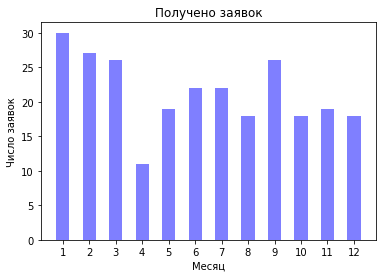

In [202]:
plt.hist(df['start_date'].dt.month, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5],
         histtype='bar',
         rwidth = 0.5,
         facecolor='b',
         alpha=0.5)

plt.xlabel('Месяц')
plt.xticks(range(1,13))
plt.ylabel('Число заявок')
plt.title('Получено заявок')
plt.show()

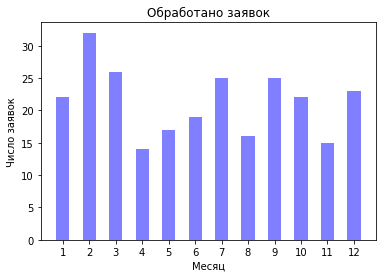

In [203]:
plt.hist(df['end_date'].dt.month, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5],
         histtype='bar',
         rwidth = 0.5,
         facecolor='b',
         alpha=0.5)
plt.xlabel('Месяц')
plt.xticks(range(1,13))
plt.ylabel('Число заявок')
plt.title('Обработано заявок')
plt.show()